(optional)

In [75]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [77]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
#
from tensorflow.keras import utils as np_utils



In [78]:
data = np.load('/content/drive/MyDrive/data.npz')
label = np.load('/content/drive/MyDrive/label.npz')


In [79]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [80]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [81]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

## Model Implementation Part

### LSTM

In [82]:
trainy = to_categorical(Y_train)
valy = to_categorical(Y_val)
print(trainy.shape, valy.shape)
print(trainy[1],Y_train[1])

(604, 6) (152, 6)
[1. 0. 0. 0. 0. 0.] [0.]


In [83]:
# Build your model here:
def evaluate_model(trainX, trainy, testX, testy):
 verbose, epochs, batch_size = 0, 15, 64
 n_timesteps, n_features, n_outputs = trainX.shape[2], trainX.shape[1], trainy.shape[1]
 model = Sequential()
 model.add(LSTM(100, input_shape=(n_features,n_timesteps)))
 model.add(Dropout(0.5))
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 a=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy,model,a

In [84]:
# summarize scores
def summarize_results(scores):
 print(scores)
 m, s = np.mean(scores), np.std(scores)
 print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# # run an experiment
# def run_experiment(repeats=10):
#  # load data
#  trainX, trainy, testX, testy = load_dataset()
#  # repeat experiment
#  scores = list()
#  for r in range(repeats):
#  score = evaluate_model(trainX, trainy, testX, testy)
#  score = score * 100.0
#  print('>#%d: %.3f' % (r+1, score))
#  scores.append(score)
#  # summarize results
#  summarize_results(scores)
 

In [85]:
scores = list()

max_s,model,a=evaluate_model(X_train, trainy, X_val, valy)
for r in range(10):
  score,m,a = evaluate_model(X_train, trainy, X_val, valy)
  score = score * 100.0
  if score>max_s:
    max_s=score
    model=m
    print("取代")
  print('>#%d: %.3f' % (r+1, score))
  scores.append(score)
# summarize results
summarize_results(scores)

取代
>#1: 69.737
取代
>#2: 76.316
>#3: 70.395
>#4: 73.026
>#5: 73.026
>#6: 73.684
>#7: 76.316
>#8: 73.684
取代
>#9: 78.947
>#10: 73.026
[69.73684430122375, 76.31579041481018, 70.3947365283966, 73.02631735801697, 73.02631735801697, 73.68420958518982, 76.31579041481018, 73.68420958518982, 78.94737124443054, 73.02631735801697]
Accuracy: 73.816% (+/-2.628)


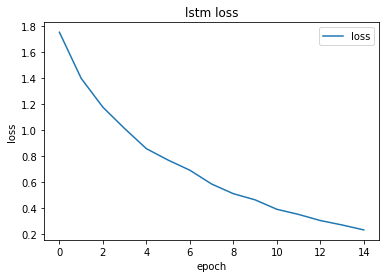

In [86]:
plt.plot(a.history['loss'])
# plt.plot(a.history['val_loss'])
plt.title('lstm loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss'], loc='upper right')
plt.show()

In [87]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 100)               120400    
                                                                 
 dropout_28 (Dropout)        (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 100)               10100     
                                                                 
 dense_53 (Dense)            (None, 6)                 606       
                                                                 
Total params: 131,106
Trainable params: 131,106
Non-trainable params: 0
_________________________________________________________________


In [88]:
ans_test=model.predict(X_test)
print(ans_test.shape)
ans=[]
for i in ans_test:
  ans.append(np.argmax(i))

ans=np.array(ans).reshape(190,1).astype(int)
print(ans[0])

6/6 [==============================] - 0s 12ms/step
(190, 6)
[0]


In [89]:
# output = "..."
assert(ans.shape == (190, 1))
np.savetxt('lstm_output.csv', ans, fmt='%i',delimiter=",")

### EEGNet

In [90]:
#导入需要的库
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
def EEGNet(nb_classes, Chans = 22, Samples = 200,
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1 = Input(shape = (Chans, Samples, 1))
    print("input shape", input1.shape, Chans, Samples, kernLength)
    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)
    flatten = Flatten(name = 'flatten')(block2)
    
    dense = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [91]:
nX_train = X_train.reshape(X_train.shape[0], 22, 200, 1)
nX_val = X_val.reshape(X_val.shape[0], 22, 200, 1)
nX_test = X_test.reshape(X_test.shape[0], 22, 200, 1)

print(nX_train.shape,nX_val.shape,nX_test.shape)

nY_train = np_utils.to_categorical(Y_train )
nY_val = np_utils.to_categorical(Y_val)
print(nY_train.shape)



(604, 22, 200, 1) (152, 22, 200, 1) (190, 22, 200, 1)
(604, 6)


In [92]:
model = EEGNet(nb_classes = 6, Chans = nX_train.shape[1], Samples = nX_train.shape[2],
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout')

input shape (None, 22, 200, 1) 22 200 32


In [93]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
# count number of parameters in the model
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 22, 200, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 200, 8)        256       
                                                                 
 batch_normalization_3 (Batc  (None, 22, 200, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 200, 16)       352       
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 200, 16)       64        
 hNormalization)                                                 
                                                           

In [94]:
fittedModel = model.fit(nX_train, nY_train, batch_size=16, epochs=300,
                        verbose=2, validation_data=(nX_val, nY_val),
                        )


Epoch 1/300
38/38 - 3s - loss: 1.6824 - accuracy: 0.3692 - val_loss: 1.6350 - val_accuracy: 0.6513 - 3s/epoch - 84ms/step
Epoch 2/300
38/38 - 2s - loss: 1.3603 - accuracy: 0.6556 - val_loss: 1.4249 - val_accuracy: 0.8618 - 2s/epoch - 59ms/step
Epoch 3/300
38/38 - 2s - loss: 1.0867 - accuracy: 0.7417 - val_loss: 1.2345 - val_accuracy: 0.8750 - 2s/epoch - 59ms/step
Epoch 4/300
38/38 - 2s - loss: 0.9507 - accuracy: 0.7947 - val_loss: 1.1006 - val_accuracy: 0.8882 - 2s/epoch - 59ms/step
Epoch 5/300
38/38 - 2s - loss: 0.8866 - accuracy: 0.7930 - val_loss: 1.0084 - val_accuracy: 0.8816 - 2s/epoch - 58ms/step
Epoch 6/300
38/38 - 2s - loss: 0.8408 - accuracy: 0.8195 - val_loss: 0.9232 - val_accuracy: 0.8882 - 2s/epoch - 58ms/step
Epoch 7/300
38/38 - 2s - loss: 0.7967 - accuracy: 0.8278 - val_loss: 0.8541 - val_accuracy: 0.9013 - 2s/epoch - 60ms/step
Epoch 8/300
38/38 - 2s - loss: 0.7657 - accuracy: 0.8576 - val_loss: 0.8169 - val_accuracy: 0.9013 - 2s/epoch - 58ms/step
Epoch 9/300
38/38 - 2s -

In [95]:
nans_test=model.predict(nX_test)
print(nans_test.shape)
nans=[]
for i in nans_test:
  # print(i)
  nans.append(np.argmax(i))

nans=np.array(nans).reshape(190,1).astype(int)


6/6 [==============================] - 0s 23ms/step
(190, 6)


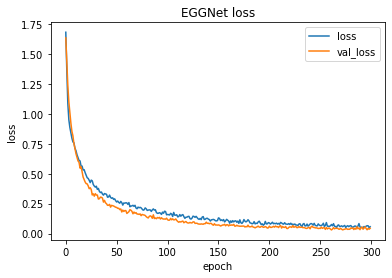

In [96]:
# plt.plot(fittedModel.history['accuracy'])
# plt.plot(fittedModel.history['val_accuracy'])
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('EGGNet loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()


In [97]:
# output = "..."
assert(nans.shape == (190, 1))
np.savetxt('eegnet_output.csv', nans,fmt='%i', delimiter=",")
np.savetxt('competition_output.csv', nans,fmt='%i', delimiter=",")

## Model Competition Part

In [98]:
# Build your model here:


In [99]:
output = "..."
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")

AttributeError: ignored